In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Adjacency Matrix

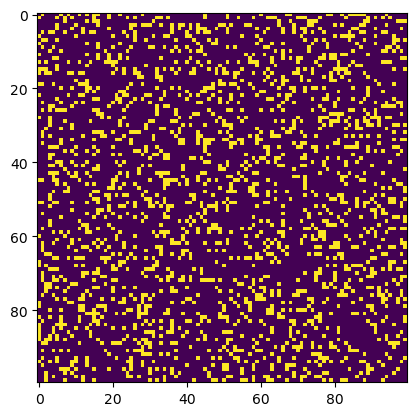

In [3]:
n = 100
dt = 0.001
T = 1

# # default, connected
# A = np.ones((n,n))
# A = np.triu(A, 1)
# A = A + A.T

# Erdos Renyi
p = .2
A = np.random.rand(n,n) # random matrix
A = np.where(A < p, 1, 0) # adjacency matrix
A = np.triu(A, 1) # triangular matrix
A = A + A.T # symmetric matrix

# # Small World
# A = np.zeros((n,n))
# for i in range(n):
#     for j in range(n):
#         if i == j:
#             continue
#         if np.abs(i-j) < 5:
#             A[i,j] = 1
#         elif np.abs(i-j) > n-5:
#             A[i,j] = 1
#         else:
#             A[i,j] = 0

# plot
plt.imshow(A)
plt.show()

### Information Accumulation Process & Kick Weight

In [4]:
mu = np.ones(n) # diffusion, i.e. correct decision
W = lambda: np.random.randn(n)*10 # drift, randon Weiner process

def dydt(A, zeta, mu, w, kicks, dt):
    """Information Accumulation Model
    Args:
        A (nxn): adjacency matrix
        zeta (nx1): drift at current time
        mu (nx1): diffusion
        w (nx1): update weights
        kicks (nx1): kick at current time
        dt (float): time step
    Returns:
        np.ndarray: dydt
    """
    return (mu + np.sqrt(2)*zeta)*dt + w*A.dot(kicks)

def dwdt(A, kappa, gamma, w, kicks, dt,tau = False):
    """Kick weights
    Args:
        A (nxn): adjacency matrix
        kappa (nx1): learning rate
        gamma (nx1): forgetting rate
        w (nx1): update weights
        kicks (nx1): kick at current time
        dt (float): time step
    Returns:
        np.ndarray: dwdt
    """
    if tau:
        t = tau
    else:
        t = 1
    return ((kappa - w)*dt - gamma*w*np.where(A.dot(np.abs(kicks)) > 1, 1, A.dot(np.abs(kicks))))/t
# TODO add tau time scale.

### Simulation

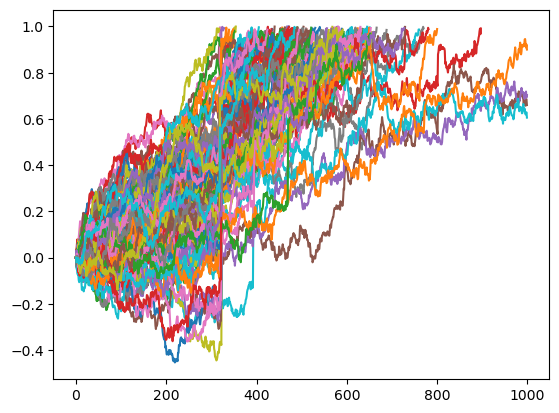

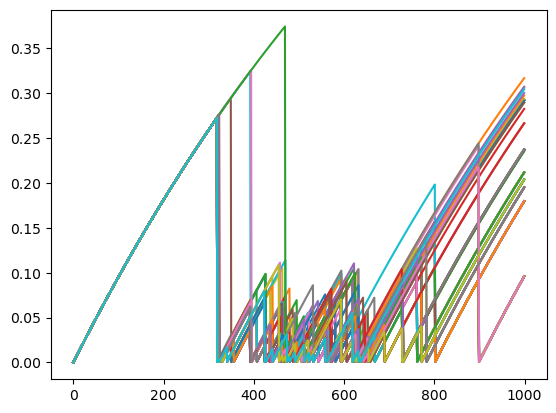

In [5]:
# parameters
kappa = 1
gamma = 1

# initial conditions
y = np.zeros((n, int(T/dt)))
w = np.zeros((n, int(T/dt)))

# initial kick
kicks = np.zeros(n)

# simulation
for t in range(int(T/dt)-1):
    # drift
    zeta = W()
    # update state
    y[:,t+1] = y[:,t] + dydt(A, zeta, mu, w[:,t], kicks, dt)
    # update kick weights
    w[:,t+1] = w[:,t] + dwdt(A, kappa, gamma, w[:,t], kicks, dt)
    # update kick
    kp = np.where(y[:,t+1] < np.inf, y[:,t+1], 0) 
    kp = kp > mu
    km = np.where(y[:,t+1] > -np.inf, y[:,t+1], 0)
    km = km < -mu
    kicks = np.where(kp, 1, 0) - np.where(km, 1, 0)
    # set to inf
    y[:,t+1] = np.where(y[:,t+1] > 1, np.inf, y[:,t+1])
    y[:,t+1] = np.where(y[:,t+1] < -1, -np.inf, y[:,t+1])


# plot
plt.plot(y.T)
plt.show()

plt.plot(w.T)
plt.show()

In [173]:
print(y[:,-41])

[       inf        inf        inf        inf        inf        inf
        inf        inf        inf        inf        inf        inf
 0.68600499        inf        inf        inf        inf        inf
        inf        inf        inf        inf        inf        inf
        inf        inf        inf        inf        inf        inf
        inf        inf        inf        inf        inf        inf
        inf        inf        inf        inf        inf        inf
        inf        inf        inf        inf        inf        inf
        inf        inf        inf        inf        inf        inf
        inf        inf        inf        inf        inf        inf
        inf        inf        inf        inf        inf        inf
        inf        inf        inf        inf        inf        inf
        inf        inf        inf        inf        inf        inf
        inf        inf        inf        inf        inf        inf
        inf        inf        inf        inf        inf       

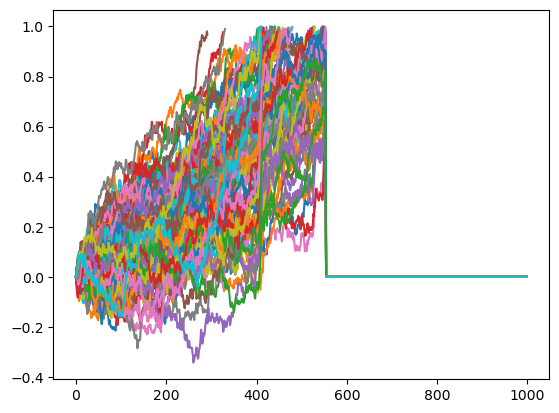

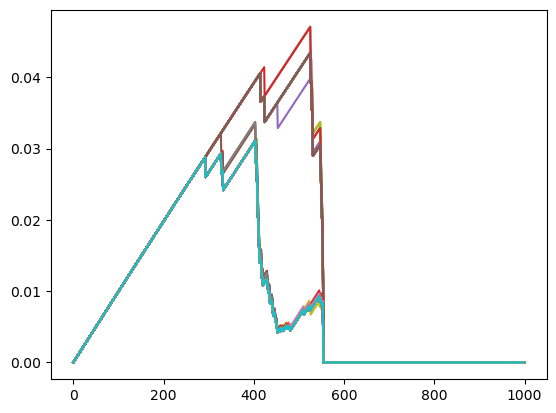

In [21]:
#Simulating for the Barbell Population Model with a Stopping Criterion
pop = np.random.randint(25,75) #minimum and maximum population sizes
A = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        if i == j:
            A[i,j] = 0
        elif (i <= pop and j <= pop) or (i > pop and j > pop):
            A[i,j] = 1
        else:
            A[i,j] = 0
sender = np.random.randint(0,pop+1)
receiver = np.random.randint(pop+1,99)
A[sender,receiver] = 1
A[receiver,sender] = 1


kappa = 1
gamma = 1
tau = 10
# initial conditions
y = np.zeros((n, int(T/dt)))
w = np.zeros((n, int(T/dt)))

# initial kick
kicks = np.zeros(n)

stop = 80 #Stopping condition when 80% of the population has decided

# simulation
for t in range(int(T/dt)-1):
    # drift
    zeta = W()
    # update state
    y[:,t+1] = y[:,t] + dydt(A, zeta, mu, w[:,t], kicks, dt)
    # update kick weights
    w[:,t+1] = w[:,t] + dwdt(A, kappa, gamma, w[:,t], kicks, dt,tau)
    # update kick
    kp = np.where(y[:,t+1] < np.inf, y[:,t+1], 0) 
    kp = kp > mu
    km = np.where(y[:,t+1] > -np.inf, y[:,t+1], 0)
    km = km < -mu
    kicks = np.where(kp, 1, 0) - np.where(km, 1, 0)
    # set to inf
    y[:,t+1] = np.where(y[:,t+1] > 1, np.inf, y[:,t+1])
    y[:,t+1] = np.where(y[:,t+1] < -1, -np.inf, y[:,t+1])
    
    cnt = 0
    for i in y[:,t+1]:
        if abs(i) == np.inf:
            cnt += 1
    if cnt >= stop:
        tstop = t
        break

# plot
plt.plot(y.T)
plt.show()
plt.plot(w.T)
plt.show()

In [32]:
def RR(yvec,correct,tstop): #Calculating the reward rate of the given population (accuracy/total time to decide)
    cor = 0
    inc = 0
    und = 0
    for i in yvec:
        if i == correct*np.inf:
            cor += 1
        elif i == -np.inf*correct:
            inc += 1
        else:
            und += 1
    return (cor/(inc+und+cor))/tstop

RR(y[:,tstop],1,tstop)

0.0014130434782608696